In [17]:
import glob
import os
import timm 
import torch
import copy
from torch.autograd import Variable
import albumentations as A

import numpy as np
import pandas as pd
from PIL import Image
import efficientnet.keras as efn

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision import transforms, models, datasets
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


METADATA_SUBSET_PATH = "/Users/franceskoback/Documents/research/pytorch_1/metadata_100subset_df.csv"

def get_manufacturer_labels(encoder, target_variable = "(0008, 0070) Manufacturer"):
    df = pd.read_csv(METADATA_SUBSET_PATH)
    df["id"] = df["id"].astype("str").str.zfill(8)
    df["code"] = encoder.fit_transform(df[target_variable])
    dictionary= {row["id"]: row["code"] for i, row in df.iterrows()}
    keys = dictionary.keys()
    values = dictionary.values()
    return dictionary

class CustomImageDataset(Dataset):
    def __init__(self):
        self.img_dir = "/Users/franceskoback/Documents/research/pytorch_1/xray_subsets"
        self.images = glob.glob(os.path.join(self.img_dir, "*.npy")) 
        self.le = preprocessing.LabelEncoder()
        self.label_map = get_manufacturer_labels(self.le)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.fromarray(np.load(img_path)).convert("RGB")
        image = transforms.ToTensor()(image)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
        image=normalize(image)
        xray_id = os.path.basename(img_path).replace(".npy", "")
        label= self.label_map[xray_id]
        label= torch.as_tensor(label)
        label= F.one_hot(label,num_classes=10)
        return (image, label)
        #return {"image": image, "label": self.label_map[xray_id]}

def train_val_test_dataset(dataset, val_split=0.20):
    train_idx, rem_idx = train_test_split(list(range(len(dataset))), test_size=val_split)

    Test_size=0.5 # split equally between validataion and test sets 
    val_idx, test_idx  = train_test_split(list(rem_idx), test_size=Test_size)

    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    datasets['test'] = Subset(dataset, test_idx)
    return datasets

[[ 1.98403772  2.02336931  1.98232765 ...  1.99771827  1.97805248
   2.23712797]
 [ 1.97292227  1.93273564  1.8797235  ...  1.99942834  1.86946308
   2.16017485]
 [ 1.88399867  1.85407246  1.75574348 ...  1.89169398  1.80362542
   2.15846478]
 ...
 [ 0.88360817 -0.78456437 -0.68709042 ... -0.63749842 -0.63236821
  -0.63151317]
 [ 0.89985383 -0.78456437 -0.67854008 ... -0.63578835 -0.62894807
  -0.62894807]
 [ 0.89301355 -0.76575361 -0.67854008 ... -0.62894807 -0.6246729
  -0.62381786]]
torch.Size([3, 224, 224])


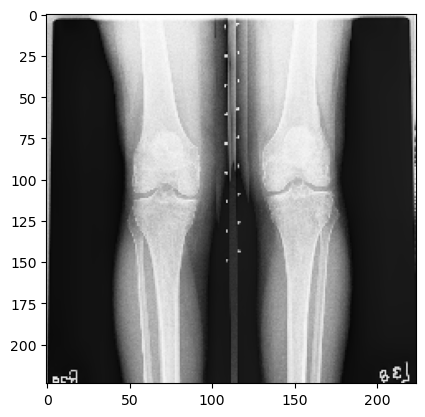

In [18]:
import numpy as np

img_array = np.load('/Users/franceskoback/Documents/research/pytorch_1/xray_subsets/00098404.npy')
from matplotlib import pyplot as plt
print(img_array)
image_ = Image.fromarray(img_array).convert("RGB")
image_ = transforms.ToTensor()(image_)
print(image_.shape)

plt.imshow(img_array, cmap='gray')
#plt.show()
#print(img_array.shape)

In [19]:
dataset = CustomImageDataset()
for (i, data) in enumerate(dataset):
        # get the inputs
        print(data)

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

In [20]:
dataset = CustomImageDataset()
datasets = train_val_test_dataset(dataset)
print(len(datasets['train'].dataset)) #6
train_dataset= datasets['train']
val_dataset= datasets['val']
test_dataset= datasets['test']


train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=True
)
valid_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=True
)

print(len(train_loader.dataset)) #6 
len_train=len(datasets['train'])
len_val= len(datasets['val'])
len_test= len(datasets['test'])

#print(test_dataset.targets)
print("Training length", len(train_loader))
print("Validation length", len(valid_loader))
print("Testing length", len(test_loader))

100
80
Training length 80
Validation length 10
Testing length 10


In [21]:
def Net(num_classes):
    model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
    
    # Freeze parameters so we don't backprop through them
    #for param in model.parameters():
    #    param.requires_grad = False

    num_ftrs = model.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model.fc = nn.Linear(num_ftrs, num_classes)

    #from collections import OrderedDict
    # classifier = nn.Sequential(OrderedDict([
    #                          ('fc1', nn.Linear(2048, 1024)), 
    #                          ('relu', nn.ReLU()),
    #                          ('fc2', nn.Linear(1024, 256)), # can experiment with these #s 
    #                          ('relu', nn.ReLU()),
    #                          ('fc3', nn.Linear(256, num_classes)), # used to be num_classes
    #                          ('output', nn.LogSoftmax(dim=1))
    #                          ]))

    #model.fc = classifier
    return model

params = {
    "model": "resnet50",
    #"device": "cuda",
    "lr": 0.001,
    "batch_size": 10, #64
    "num_workers": 1, #20
    "n_epochs": 50, #100
    "image_size": 224, 
    "in_channels": 2, #3
    "num_classes": 10, #12
    "device": "cpu"
}

model = Net(params['num_classes'])
model.eval().to(params["device"])
#loss_fn = nn.NLLLoss() 
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = params['lr'])
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))


80
10
10


In [57]:
def areEqual(arr1, arr2):
    N= len(arr1)
    M= len(arr2)
    if (N !=M):
        print("arrays do not have the same size")
        return False 

    for i in range(0, N):
        if (arr1[i] != arr2[i]):
            return False
 
    # If all elements were same.
    return True

In [66]:
def train_one_epoch(epoch, model, loss_fn, optimizer, loader, device = "cpu"):
    #put model in training state
    model.train()
    train_loss = 0.0
    running_loss=0.0
    loss_values=[]

    for batch_idx, (img,label) in enumerate(loader):  
        inputs = Variable(img.to(device).float(),requires_grad=True)
        labels = Variable(label.to(device).float(),requires_grad=True)
        
        optimizer.zero_grad() # sets all grads to None 

        # forward + backward + optimize
        outputs = model(inputs)
        pred = torch.argmax(outputs, dim=1)
        outputs = torch.zeros_like(labels).scatter_(1, pred.unsqueeze(1), 1.)
        #print("outputs are",outputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item() # * images.size(0) ?
        loss_values.append(running_loss)
        

        # print statistics
        #running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
         #   print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #running_loss=0
          #  i=i+1
        
        train_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        # if batch_idx%5==0:
        #     print('train loss', train_loss)
        if batch_idx % 10 == 0:
            loss, current = loss.item(), batch_idx * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(loader):>5d}]")
    
    
    print('Epoch {} avg Training loss: {:.3f}'.format(epoch+1, train_loss))
    return model, train_loss



def test_one_epoch(epoch, model, loss_fn, loader, len_val, device = "cpu"):
    model.eval()

    #pbar = tqdm(enumerate(test_loader), total = len(test_loader))
    running_loss = 0
    actual_labels = []
    pred_labels = []
    loss_values=[]
    
    #for step, (imgs, labels) in pbar:
    for batch_idx, (img,label) in enumerate(loader):    
        inputs =img
        labels = label
        
        
        inputs = Variable(inputs.to(device).float())
        labels = Variable(labels.to(device).float())
        
        log_preds = model(inputs)
        loss = loss_fn(log_preds, labels)
        loss.backward()
        optimizer.step()

        loss_values.append(running_loss)
        


        preds = torch.exp(log_preds)
        running_loss+=((1 / (batch_idx + 1)) * (loss.data.item() - running_loss))
        
        #calculate accuracy
        top_prob, top_class = preds.topk(1, dim=1)
        pred_labels+= list((top_class.view(-1)).cpu().numpy())
        actual_labels+= list(labels.cpu().numpy())
        
        

        # epoch_loss = running_loss / dataset_sizes[phase]
        # epoch_acc = running_corrects.double() / dataset_sizes[phase]
    
    
    print("pred_labels!! ")
    #print((np.array(pred_labels)==np.array(actual_labels)))
    print(pred_labels)
    print("actual_labels")
    print(actual_labels)
    accuracy = ((np.array(pred_labels)==np.array(actual_labels)).sum())/len(pred_labels) #size of test set
    correct = ((np.array(pred_labels)==np.array(actual_labels)).sum())
    total = len(pred_labels)
    
    
    return running_loss, accuracy, correct, total

## Training Loop

In [67]:
train_losses = []
valid_losses = []

for epoch in range(params['n_epochs']):
    train_loss = train_one_epoch(epoch, model, loss_fn, optimizer, train_loader)
    train_losses+= [train_loss]
    valid_loss, accuracy, correct, total = test_one_epoch(epoch, model, loss_fn, valid_loader, len_val)
    valid_losses+=[valid_loss]
    print('Epoch {} avg Valid loss: {:.3f}'.format(epoch+1, valid_loss))
    print('Epoch {} Valid accuracy: {:.1%} ({} of {} right)\n'.format(epoch+1, accuracy, correct, total))
    if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, 'checkpoint.tar')

    


loss: 0.200000  [    0/   80]
loss: 0.200000  [   10/   80]
loss: 0.200000  [   20/   80]
loss: 0.200000  [   30/   80]
loss: 0.200000  [   40/   80]
loss: 0.200000  [   50/   80]
loss: 0.200000  [   60/   80]
loss: 0.200000  [   70/   80]
Epoch 1 avg Training loss: 0.185
pred_labels!! 
[6, 6, 2, 2, 2, 2, 6, 0, 8, 8]
Epoch 1 avg Valid loss: 24.657
Epoch 1 Valid accuracy: 100.0% (10 of 10 right)

loss: 0.200000  [    0/   80]
loss: 0.200000  [   10/   80]
loss: 0.200000  [   20/   80]
loss: 0.200000  [   30/   80]
loss: 0.200000  [   40/   80]
loss: 0.200000  [   50/   80]
loss: 0.200000  [   60/   80]
loss: 0.200000  [   70/   80]
Epoch 2 avg Training loss: 0.198
pred_labels!! 
[8, 8, 8, 0, 0, 0, 0, 0, 0, 0]
Epoch 2 avg Valid loss: 17.133
Epoch 2 Valid accuracy: 640.0% (64 of 10 right)

loss: 0.200000  [    0/   80]
loss: 0.200000  [   10/   80]
loss: 0.200000  [   20/   80]
loss: 0.200000  [   30/   80]
loss: 0.200000  [   40/   80]
loss: 0.200000  [   50/   80]
loss: 0.200000  [   60

KeyboardInterrupt: 

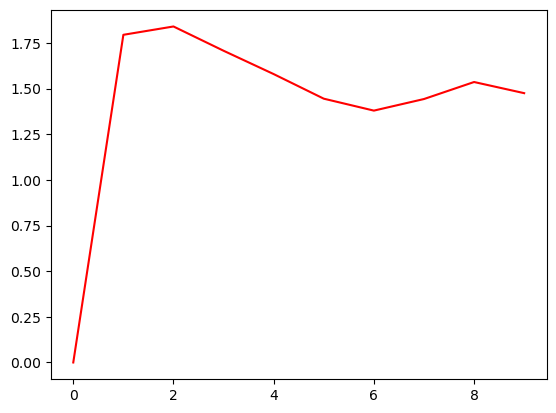

In [39]:
plt.plot(np.array(loss_values), 'r')

In [26]:
# load the model that got the best validation accuracy
checkpoint = torch.load('checkpoint.tar')
loaded_model = Net(params['num_classes'])
loaded_model.to(params["device"])
loaded_model.load_state_dict(checkpoint['model_state_dict'])

loaded_criterion = checkpoint['loss']

#optimizer = optim.Adam(model.parameters(), lr = 0.003)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

last_epoch = checkpoint['epoch']+1

test_loss, accuracy, correct, total = test_one_epoch(None, loaded_model, loaded_criterion, test_loader, len_val)

print('Test loss: {:.3f}'.format(test_loss))
print('Test accuracy: {:.1%} ({} of {} right)\n'.format(accuracy, correct, total))

length of loader
10
Test loss: 0.136
Test accuracy: 560.0% (56 of 10 right)

